## Calculateクラス
### LoadData(): データを読みこむメソッド
- @param pop: 人口メッシュデータ（中心緯度経度、人口データを持つgeojson形式のデータ）
- @param com: 商業集積地区データ（中心緯度経度、売り場面積、売上高を持つgeojson形式のデータ）
            
### Dist(): ヒュべニの公式を用いた二点の距離を求めるメソッド
- @param p1: 緯度経度をリストで持つ地点
- @param p2: 緯度経度をリストで持つ地点

### oneAttract(): 顧客が店舗に行く確率を求めるメソッド
- @apram distList: すべての店舗までの距離のリスト
- @param areaList: すべての店舗の売場面積のリスト
- @param area: 面積補正係数
- @param dist: 距離補正係数
- @return 店舗の魅力度のリスト

### CleanList(): リストの-9999を0に変換するメソッド
- @param ln: 変換するリスト
- @return 変換後のリスト

### PredictSale(): 売上高を求めるメソッド
- @param pop_ptList 人口メッシュの緯度経度リスト
- @param pop_popList 人口メッシュの人口リスト
- @param com_ptList 商業施設の緯度経度リスト
- @param com_areaList 商業施設の売り場面積リスト
- @param area,dist 面積補正係数,距離補正係数
- @return predictSale 売上の予測値

## ライブラリ

In [1]:
import numpy as np
import json
import tqdm
from huffcalculate import Calculate
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Calculateクラスのコンストラクタ

In [2]:
calculate = Calculate('100_pop.geojson', 'A_com.geojson', 0.489773)
(pop, com) = calculate.LoadData()

## GeoJSON形式を読み込む

In [6]:
#100mメッシュの点を取得
pop_ptList = [i['geometry']['coordinates'] for i in pop['features']]
#商業施設座標の取得
com_ptList = [i['geometry']['coordinates'] for i in com['features']]

#売場面積の取得
com_areaList = [i['properties']['売場面積'] for i in com['features']]
com_areaList = [n.replace('X', '0') for n in com_areaList]
com_areaList = np.array([float(n.replace(',', '')) for n in com_areaList])
#100mメッシュの人口を取得, -9999を0に変換
pop_popList = [i['properties']['H27総人口'] for i in pop['features']]
pop_popList = calculate.CleanList(pop_popList)

#売り上げを取得
com_saleList = [i['properties']['年間商品販売額'] for i in com['features']]
#秘匿をゼロに
com_saleList = [n.replace('X', '0') for n in com_saleList]
com_saleList = np.array([float(n.replace(',', '')) for n in com_saleList])

#出力用に取得
#meshcodeの取得
pop_meshcodeList = [i['properties']['MESHCODE'] for i in pop['features']]
#keycodeの取得
pop_keycodeList = [i['properties']['KEYCODE'] for i in pop['features']]

#idを作成
id = np.arange(len(com_areaList))

## 比例定数の算出
- 売上高/人口 = k(円/人)

In [7]:
popSum = np.sum(pop_popList)
saleSum = np.sum(com_saleList)
k = 2956541 / popSum*0.37
k

0.485898751112213

## 係数の定義
- @param area: 面積のべき数
- @param dist: 距離のべき数

In [8]:
area = 0.9
dist = 1.4

## 売上高の予測

In [9]:
predictList = calculate.PredictSale(pop_ptList, pop_popList, com_ptList, com_areaList, area, dist, 400)

100%|██████████| 32564/32564 [03:00<00:00, 180.53it/s]


## 残差の計算

In [14]:
e = com_saleList - k*predictList

## 平均二乗誤差

In [15]:
RMSE = np.sqrt(np.sum(e**2)/len(com_saleList))
RMSE

11564.539733807645

## 残差プロット

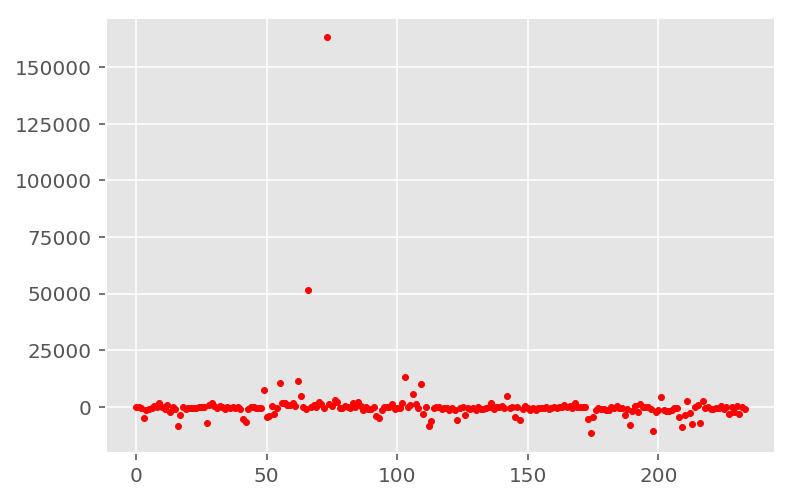

In [16]:
plt.scatter(id, e, c='red', marker='.')

## 理論値売上に対する誤差

In [17]:
sum(abs(e))/len(com_saleList)

2571.1395516121374

/Users/Yoshimasa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


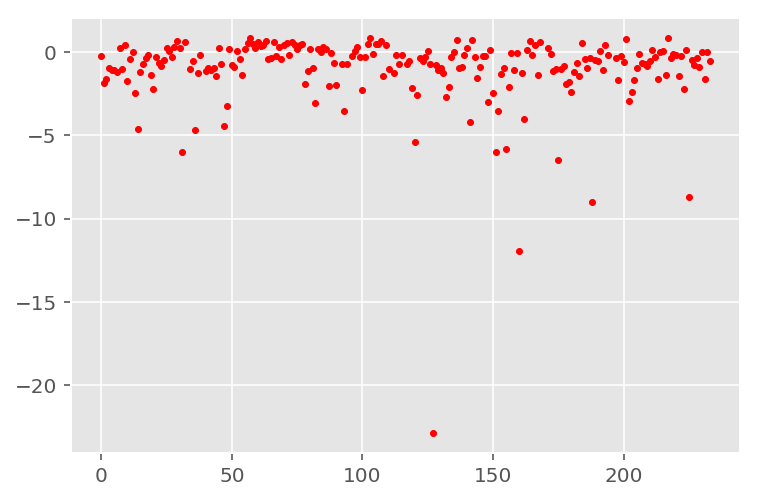

In [18]:
plt.scatter(id, e/com_saleList, c='red', marker='.')

In [19]:
x = predictList*k

In [20]:
y = com_saleList

In [21]:
np.corrcoef(x,y)

array([[1.        , 0.89021081],
       [0.89021081, 1.        ]])